# Immigration in Europe

### Legend:
- h2: each person's contribution
- h3: individual work sections

In [69]:
# importing libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import numpy as np
import seaborn as sns

import geopandas
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import Markdown

## Jakub 

### Foregin born residents in country

In [83]:
url = "https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/Annual_population_eurostat(mandatory).csv"
table = pd.read_csv(url)
year_offset = 4

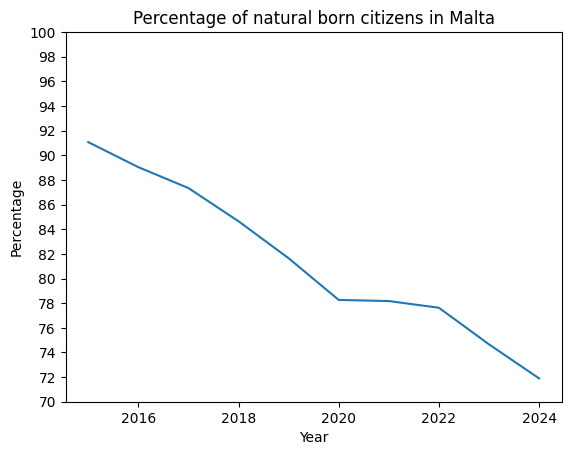

In [84]:
def percent_natural_born(country,title):
    pop_new = []
    country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
    country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")

    try:
        for i in range(10):
            pop_new.append(country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100)

        dataframe = pd.DataFrame({'year': range(2015,2025,1),
                           'percentage': pop_new})

        figure, axes = plt.subplots()
        axes.plot(dataframe['year'], dataframe['percentage'])

        axes.set_xlabel('Year')
        axes.set_ylabel('Percentage')
        
        

        y_min = 70
        step = 2
        
        if min(dataframe["percentage"]<y_min):
            y_min = 50

        axes.set_ylim(y_min)
        axes.set_yticks(range(y_min,100+step,step))

        axes.set_title(title)
        
        #Saving figure
        # These lines are commented for demonstration purposes

        # dir_name = "../Images/Countries/"+country
        # try:
        #     os.makedirs(dir_name)
        #     # print(f"Directory '{dir_name}' created successfully!")
        # except FileExistsError:
        #     pass
        #     # print(f"Directory '{dir_name}' already exists.")
        # except Exception as e:
        #     pass
        #     # print(f"Error creating directory: {e}")
        
        # figure.savefig(dir_name+"/natural_percent_"+country.lower()+".png")
        # plt.close(figure)
        pass
    except Exception as e:
            print("Unable to process",country,":",e)

# display(table.query("Country == 'Malta' and sex=='T'"))
percent_natural_born("Malta",'Percentage of natural born citizens in Malta')


### Getting ratios of people of type over the years


- Result is rounded to 2 decimal places


Documentation:
- get_ratio_dataframe expects one argument: *citizenship_type*. if left **None**, it will calculate all foreigners.
- citizenship_type can be in
    - **EU28_FOR**: EU28 countries (2013-2020) except reporting country
    - **NEU28_FOR**: Non-EU28 countries (2013-2020) nor reporting country
    - **NAT**: Reporting country
    - **STLS**: Stateless
    - **TOTAL**: Total
    - **UNK**: Unknown

In [72]:
def get_citizenship_ratio(country,citizenship_type):
    try:
        foreign_ratios = []
        country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
        iso3 = country_main.iloc[0,1]

        if citizenship_type is not None:
            country_foreign = table.query("Country =='"+country+"' and sex=='T' and citizen == '"+citizenship_type+"'")
        
            for i in range(10):
                foreign_ratios.append((country_foreign.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i]*100))

        #Calculate all foreign residents
        else:
            country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")
            for i in range(10):
                foreign_ratios.append((100-((country_natural.iloc[0,year_offset + i]/country_main.iloc[0,year_offset + i])*100)).round(2))
        
        years = [str(x+2015) for x in range(10)]

        series_data = [iso3] + foreign_ratios
        index_labels = ['ISO3'] + years
        
        return pd.Series(series_data, index=index_labels, name=country)
        
    except:
        # print("Error processing country: ",country)
        return None
    
def get_ratio_dataframe(citizenship_type=None):
    results = []

    for country in table["Country"].unique():
        result = get_citizenship_ratio(country,citizenship_type)
        if result is not None:
            results.append(result.to_dict())

    return pd.DataFrame.from_records(results).set_index("ISO3")


#### Get total amount for type


In [73]:
def get_citizenship_total(country,citizenship_type):
    try:
        foreign_ratios = []
        country_main = table.query("Country =='"+country+"' and sex=='T' and citizen == 'TOTAL'")
        iso3 = country_main.iloc[0,1]

        if citizenship_type is not None:
            country_foreign = table.query("Country =='"+country+"' and sex=='T' and citizen == '"+citizenship_type+"'")
        
            for i in range(10):
                foreign_ratios.append((country_foreign.iloc[0,year_offset + i]))

        #Calculate all foreign residents
        else:
            country_natural = table.query("Country =='"+country+"' and sex=='T' and citizen == 'NAT'")
            for i in range(10):
                foreign_ratios.append((country_main.iloc[0,year_offset + i]-country_natural.iloc[0,year_offset + i]))
        
        years = [str(x+2015) for x in range(10)]

        series_data = [iso3] + foreign_ratios
        index_labels = ['ISO3'] + years
        
        return pd.Series(series_data, index=index_labels, name=country)
        
    except:
        # commented out for presentation purposes
        # print("Error processing country: ",country)
        return None
    
def get_total_dataframe(citizenship_type=None):
    results = []

    for country in table["Country"].unique():
        result = get_citizenship_total(country,citizenship_type)
        if result is not None:
            results.append(result.to_dict())

    return pd.DataFrame.from_records(results).set_index("ISO3")


#### Get absolute change for type

In [74]:
def get_change_total(year1,year2,citizenship_type=None):
    #gets the original table from get_total_dataframe
    original_table = get_total_dataframe(citizenship_type)
    # display(original_table.head())

    change_dict = dict()

    for index,row in original_table.reset_index().iterrows():
        # print(type(row))
        # print(row["ISO3"],row[str(year2)]-row[str(year1)])
        change_dict[row["ISO3"]] = row[str(year2)]-row[str(year1)]

    
    change_df = pd.DataFrame(list(change_dict.items()), columns=["ISO3", "Change"])#I used ChatGPT for this line

    change_df.set_index("ISO3", inplace=True)
    return change_df


### Europe map drawing function

#### Documentation
- draw_choropleth accepts 4 arguments:
    - data: data
    - column: color of countries
    - range = **None**: range of color, set to auto by default
    - save_name = **None**: name of destination file, not exporting by default

In [75]:
def draw_choropleth(data, column,range=None,save_name=None,title="",scale=""):
  if range is not None:
    fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant",
      range_color=range
    )
  else:
      fig = px.choropleth(
      data, locations=data.index, color=column,
      projection = "azimuthal equidistant"
      )

  fig.update_geos(lonaxis_range= [-20, 40],lataxis_range= [30, 72])
  fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":30},
                    title={
        'text': title,
        'y':0.96,  # Position from top (0 to 1)
        'x':0.5,    # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=18) })
  
  
  
  #I used Deepseek AI to write this code
  if save_name:
    try:
      fig.write_image(f"../Images/Maps/{save_name}.png", scale=4)
      print(f"Successfully saved to {save_name}.png")
    except Exception as e:
      print(f"Could not save PNG: {str(e)}")
      print("Install kaleido with: pip install -U kaleido")
  else:
    fig.show()

  

#### Drawing

In [76]:
# Percentage of EU born
display_countries = get_ratio_dataframe("EU28_FOR")
year = 2020
title="Percentage of immigrants born in EU countries in "+str(year)
draw_choropleth(display_countries, str(year),(0,30),None,title)

# Percentage of non-EU born

display_countries = get_ratio_dataframe("NEU28_FOR")
year = 2020
title="Percentage of non-EU immigrants countries in "+str(year)
draw_choropleth(display_countries, str(year),(0,15),None,title)

display_countries = get_total_dataframe("EU28_FOR")
year = 2020
title="Total number of immigrants born in EU countries in "+str(year)
draw_choropleth(display_countries, str(year),(0,4.5e6),None,title)

year1 = 2015
year2 = 2020
display_countries = get_change_total(year1,year2,"EU28_FOR")
title="Change of immigrants from EU countries between "+str(year1) +" and "+str(year2)

draw_choropleth(display_countries, "Change",(0,1e6), None,title)


### District information in Slovakia

In [97]:
net_migration_raw = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/slovakia/net_migration_districts_sk.csv")
unemployment_migration_raw = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/slovakia/unemployment_districts_sk.csv")
monthly_salary_raw = pd.read_csv("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/slovakia/average_montly_salary_districts_sk.csv")


districts_geodata = geopandas.read_file("https://raw.githubusercontent.com/jatofi-official/migration-eu-analysis/main/Data/geography/slovak_districts.json")


districts_net_migration = pd.merge(districts_geodata,net_migration_raw,on="LAU1_CODE")
districts_unemployment = pd.merge(districts_geodata,unemployment_migration_raw,on="LAU1_CODE")
districts_salary = pd.merge(districts_geodata,monthly_salary_raw,on="LAU1_CODE")



#### Largest/smallest value in counties

In [91]:
def district_value_total(table,ascending = True):
    data = []
    
    for index,row in table.iterrows():
        name = row["NM3"]
        geography = row["geometry"]
        total = 0
        for year in range(1995,2024,1):
            total += row[str(year)]

        data.append({"District":name,
                     "geometry":geography,
                     "value":total})
    result_df = geopandas.GeoDataFrame(data)
    result_df.sort_values(by="value",ascending=ascending,inplace=True)
    # display(result_df.head())
    return result_df

# district_value_total(districts_net_migration,ascending=False)

### Slovakia district drawing function

In [92]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_districts(table, target_column, title_label="", colorbar_label="Value",fixed_max_value=None,fixed_min_value=None,filename="",color_scheme = ["red", "lightgray", "green"],biggest_text="Biggest net gain",smallest_text = "Biggest net loss"):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if fixed_max_value is None:
        max_value = max([abs(x) for x in table[target_column]])
        # print("Max value: ",max_value)
    else:
        max_value = fixed_max_value
    

    cmap = LinearSegmentedColormap.from_list("red_green", color_scheme)
    if fixed_min_value is None:
        min_value = -max_value
    elif fixed_min_value == "min":
        min_value = min([x for x in table[target_column]])
        # print(min_value)

    else:
        min_value = fixed_min_value
    
    norm = Normalize(vmin=min_value,vmax=max_value)

    # axes = table.plot(column = target_column,legend=True,cmap=cmap,norm=norm,edgecolor="gray",linewidth=0.3)

    table.plot(
        column=target_column,
        cmap=cmap,
        norm=norm,
        edgecolor="gray",
        linewidth=0.3,
        ax=ax,
        legend=False
    )

    # I used ChatGPT to write this paragraph of code
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label(colorbar_label, fontsize=10)


    ax.set_title(title_label, fontsize=18,  pad=15)
    ax.set_axis_off()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    #Net gain and loss
    gain_table = table.sort_values(str(target_column),ascending=False).head()
    
    loss_table = table.sort_values(str(target_column),ascending=True).head()

    #constant, change here:
    n_districts = 5
    gain = []
    loss = []
    
    for i in range(n_districts):
        gain.append((gain_table.iloc[i,0],float(gain_table.iloc[i,:][str(target_column)])))
        loss.append((loss_table.iloc[i,0],float(loss_table.iloc[i,:][str(target_column)])))
    
    gain_text = rf"$\bf { "\\ ".join(biggest_text.split())}$"+"\n"

    for district,value in gain:
        gain_text += district + ": "+ f"{value:.1f}" + "\n"
    
    loss_text = rf"$\bf {"\\ ".join(smallest_text.split())}$"+"\n"
    for district,value in loss:
        loss_text += district + ": "+ f"{value:.1f}" + "\n"

    plt.figtext(0.4, 0.1, gain_text, ha='left', fontsize=9, wrap=False)
    plt.figtext(0.6, 0.1, loss_text, ha='left', fontsize=9, wrap=False)

    plt.tight_layout()
    if filename != "":
        # os.makedirs("../../Images/Slovakia",exist_ok=True)
        plt.savefig("../../Images/Slovakia/"+filename+".png")
        plt.close()
    else:
        plt.show()

# draw_districts(districts_net_migration, str(2020), title_label="District migration in "+str(2020), colorbar_label="Total migration change",filename="")


#### Drawing different maps in 2020

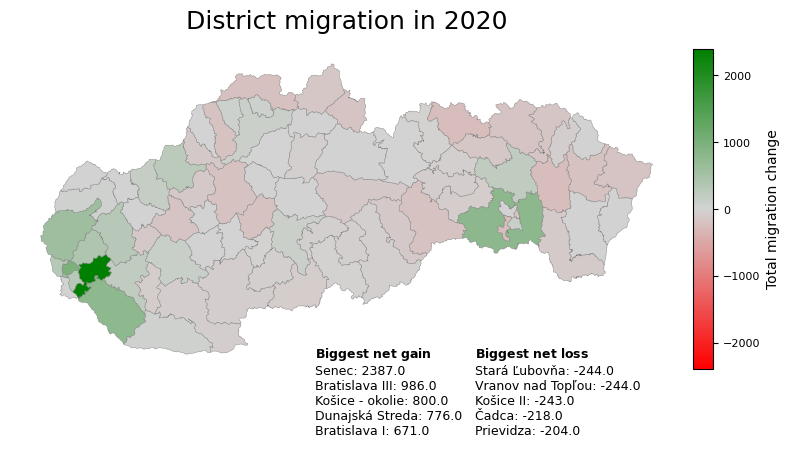

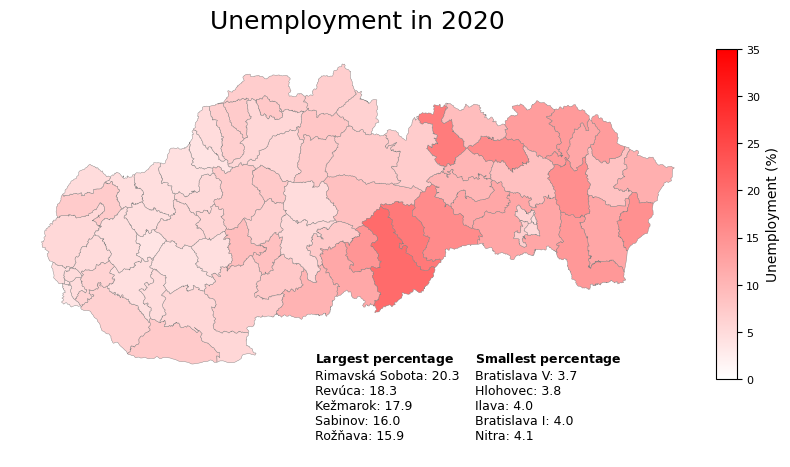

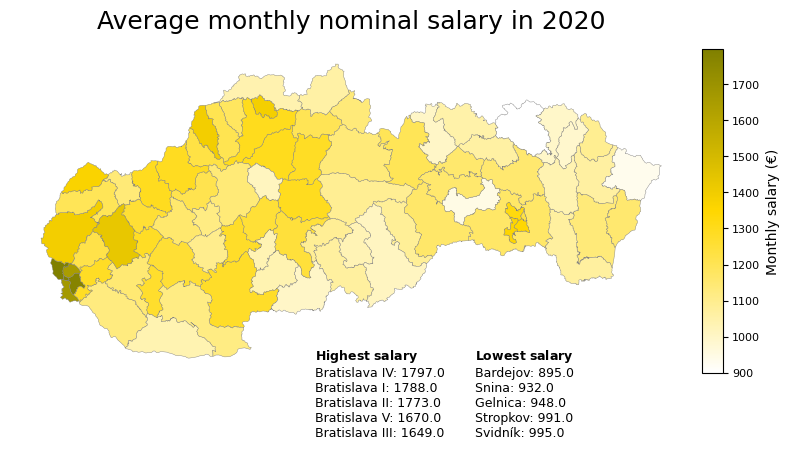

In [98]:
# migration
draw_districts(districts_net_migration, str(2020), title_label="District migration in "+str(2020), 
               colorbar_label="Total migration change",filename="")

# unemployment
draw_districts(districts_unemployment, str(2020), title_label="Unemployment in "+str(2020), 
                colorbar_label="Unemployment (%)",fixed_min_value=0,color_scheme=["white","red"],
                biggest_text="Largest percentage",
                smallest_text="Smallest percentage",fixed_max_value=35)

# monthly salary
draw_districts(districts_salary, str(2020), title_label="Average monthly nominal salary in "+str(2020), 
                colorbar_label="Monthly salary (€)",fixed_min_value=900,color_scheme=["white","gold","olive"],
                biggest_text="Highest salary",
                smallest_text="Lowest salary")

#### Drawing total change


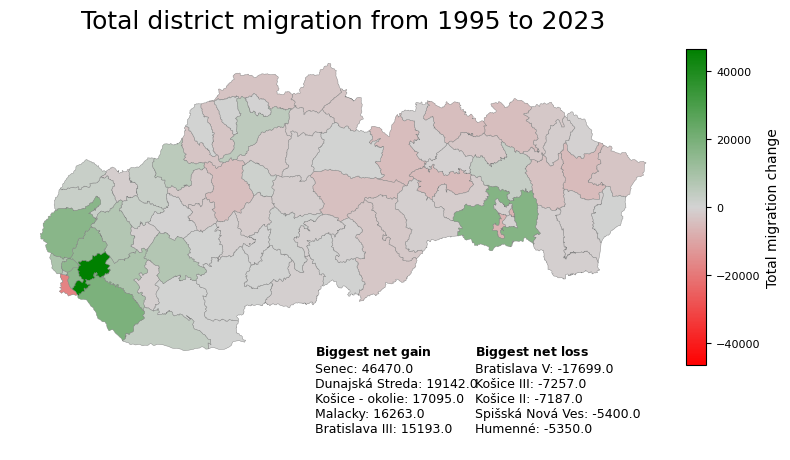

In [95]:
#Total change
total_table = district_value_total(districts_net_migration,True)
# display(total_table.head())
draw_districts(total_table,target_column="value",title_label="Total district migration from 1995 to 2023",colorbar_label="Total migration change",filename="")

# Andrej


# Adam


# Erik

# Adrian